In [1]:
# Import required libraries
from pathlib import Path
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance
from sklearn.inspection import permutation_importance
import numpy as np
import shap
import seaborn as sns
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Import data from CSV files
costar_1 = pd.read_csv(Path("Resources/CostarExport.csv"))
costar_2 = pd.read_csv(Path("Resources/CostarExport-2.csv"))
costar_3 = pd.read_csv(Path("Resources/CostarExport-3.csv"))
costar_4 = pd.read_csv(Path("Resources/CostarExport-4.csv"))
costar_5 = pd.read_csv(Path("Resources/CostarExport-5.csv"))


In [3]:
# Create Dataframe
combined_df = pd.concat([costar_1, costar_2, costar_3, costar_4, costar_5])
costar_df = combined_df.drop(columns=["Zoning", "Rent/SF/Yr","Avg Effective/SF", "Ceiling Ht", "Submarket Name", "City", "Amenities", "Zip", "Features"])
costar_df.shape

(1773, 26)

In [4]:
costar_df.head()

,% 1-Bed,% 2-Bed,% 3-Bed,% 4-Bed,% Studios,Avg Effective/Unit,Avg Unit SF,Building Class,Closest Transit Stop Dist (mi),Four Bedroom Avg SF,...,Number Of Units,One Bedroom Avg SF,Parking Ratio,RBA,Studio Avg SF,Style,Three Bedroom Avg SF,Two Bedroom Avg SF,Year Built,Year Renovated
0,85.11,10.64,2.13,NaN,2.13,1033.0,657.0,B,17.28,NaN,...,47,624.0,1.95,30780,500.0,Low-Rise,1400.0,800.0,1975,NaN
1,26.39,73.61,NaN,NaN,NaN,1247.0,653.0,C,6.37,NaN,...,72,522.0,1.53,46980,NaN,Garden,NaN,700.0,1977,2015.0
2,41.54,52.31,3.08,NaN,3.08,1068.0,761.0,B,0.42,NaN,...,65,612.0,1.10,46975,500.0,Garden,938.0,885.0,1972,2019.0
3,25.00,50.00,25.00,NaN,NaN,997.0,875.0,C,NaN,NaN,...,32,750.0,NaN,26433,NaN,Garden,1050.0,850.0,1974,NaN
4,1.89,88.68,5.66,0.0377,NaN,1315.0,888.0,C,NaN,1120.0,...,53,600.0,NaN,48060,NaN,Garden,995.0,878.0,1972,NaN


In [5]:
costar_df.dtypes

% 1-Bed                           float64
% 2-Bed                           float64
% 3-Bed                           float64
% 4-Bed                           float64
% Studios                         float64
Avg Effective/Unit                float64
Avg Unit SF                       float64
Building Class                     object
Closest Transit Stop Dist (mi)    float64
Four Bedroom Avg SF               float64
Land Area (AC)                    float64
Latitude                          float64
LEED Certified                     object
Longitude                         float64
Number Of Elevators                 int64
Number Of Stories                   int64
Number Of Units                     int64
One Bedroom Avg SF                float64
Parking Ratio                     float64
RBA                                 int64
Studio Avg SF                     float64
Style                              object
Three Bedroom Avg SF              float64
Two Bedroom Avg SF                

In [6]:
# Define list of categorical variables
categorical_variables = list(costar_df.dtypes[costar_df.dtypes == "object"].index)
categorical_variables

['Building Class', 'LEED Certified', 'Style']

In [7]:
# Create OneHotEncoder Instance
enc = OneHotEncoder(sparse=False)

In [8]:
# Encode the categorical variables with OneHotEncoder
encoded_data = enc.fit_transform(combined_df[categorical_variables])

In [9]:
encoded_df = pd.DataFrame(encoded_data, columns=enc.get_feature_names_out(categorical_variables))
# Change index type to Int64 from Range
encoded_df.index = list(encoded_df.index)
encoded_df.reset_index(inplace=True)

In [11]:
# Add numerical variables from the original DataFrame to the encoded DataFrame
num_df = costar_df.drop(columns=categorical_variables)

num_df.reset_index(inplace=True)
num_df.merge(encoded_df, how="inner", left_on="index", right_on="index")

# Move target feature to last column
column_to_move = num_df.pop("Avg Effective/Unit")
num_df.insert(23, "Avg Effective/Unit", column_to_move)

#Review the DataFrame
num_df.dtypes


index                               int64
% 1-Bed                           float64
% 2-Bed                           float64
% 3-Bed                           float64
% 4-Bed                           float64
% Studios                         float64
Avg Unit SF                       float64
Closest Transit Stop Dist (mi)    float64
Four Bedroom Avg SF               float64
Land Area (AC)                    float64
Latitude                          float64
Longitude                         float64
Number Of Elevators                 int64
Number Of Stories                   int64
Number Of Units                     int64
One Bedroom Avg SF                float64
Parking Ratio                     float64
RBA                                 int64
Studio Avg SF                     float64
Three Bedroom Avg SF              float64
Two Bedroom Avg SF                float64
Year Built                          int64
Year Renovated                    float64
Avg Effective/Unit                

In [12]:
# Clean up DataFrame Fillna
num_df = num_df.fillna(0)
num_df.head()

,index,% 1-Bed,% 2-Bed,% 3-Bed,% 4-Bed,% Studios,Avg Unit SF,Closest Transit Stop Dist (mi),Four Bedroom Avg SF,Land Area (AC),...,Number Of Units,One Bedroom Avg SF,Parking Ratio,RBA,Studio Avg SF,Three Bedroom Avg SF,Two Bedroom Avg SF,Year Built,Year Renovated,Avg Effective/Unit
0,0,85.11,10.64,2.13,0.0000,2.13,657.0,17.28,0.0,1.5700,...,47,624.0,1.95,30780,500.0,1400.0,800.0,1975,0.0,1033.0
1,1,26.39,73.61,0.00,0.0000,0.00,653.0,6.37,0.0,1.7900,...,72,522.0,1.53,46980,0.0,0.0,700.0,1977,2015.0,1247.0
2,2,41.54,52.31,3.08,0.0000,3.08,761.0,0.42,0.0,1.8900,...,65,612.0,1.10,46975,500.0,938.0,885.0,1972,2019.0,1068.0
3,3,25.00,50.00,25.00,0.0000,0.00,875.0,0.00,0.0,2.0000,...,32,750.0,0.00,26433,0.0,1050.0,850.0,1974,0.0,997.0
4,4,1.89,88.68,5.66,0.0377,0.00,888.0,0.00,1120.0,1.0615,...,53,600.0,0.00,48060,0.0,995.0,878.0,1972,0.0,1315.0


<AxesSubplot:>

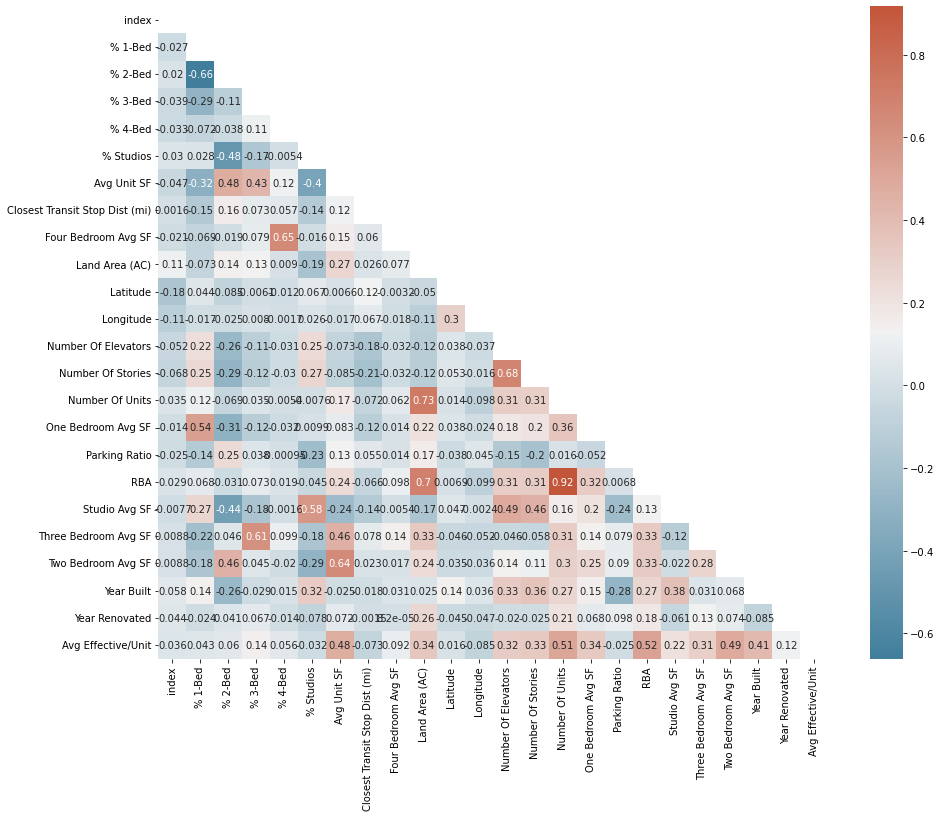

In [13]:
# Feature correlation heatmap with Seaborn
corr = num_df.corr()

#Set up matplotlib configuration
f, ax = pyplot.subplots(figsize=(15, 12))

# Generate a mask for upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configure a cumstom diverging colormap
cmap=sns.diverging_palette(230, 20, as_cmap=True)
    
# Draw the heatmap
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap)

In [14]:
# Separate target feature and rest of the features using .iloc to subset the data
X= num_df.drop(columns="Avg Effective/Unit")
y = num_df["Avg Effective/Unit"]
print(y[0:5])

0    1033.0
1    1247.0
2    1068.0
3     997.0
4    1315.0
Name: Avg Effective/Unit, dtype: float64


In [15]:
# Split the features and target sets into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [16]:
# Define model hyperparameters
xg_reg = xgb.XGBRegressor(objective="reg:squarederror", colsample_bytree = 0.3, learning_rate=0.1,
                          max_depth=5, alpha = 10, n_estimators = 10)

In [17]:
# Fit the model
xg_reg.fit(X_train, y_train)

# Make predictions
preds = xg_reg.predict(X_test)

In [18]:
# RMSE
rmse = np.sqrt(mean_squared_error(y_test, preds))

print("RMSE: %f" % (rmse))

RMSE: 599.214886


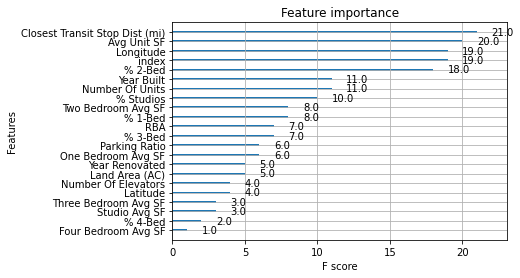

In [19]:
# Plot feature importance
plot_importance(xg_reg)
pyplot.show()

In [20]:
# Initiate the model instance
regressor = RandomForestRegressor(n_estimators=10, random_state=1)

In [21]:
# Define features
X= num_df.drop(columns="Avg Effective/Unit")
y = num_df["Avg Effective/Unit"]
print(y[0:5])

0    1033.0
1    1247.0
2    1068.0
3     997.0
4    1315.0
Name: Avg Effective/Unit, dtype: float64


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [23]:
# Fit the model using the training data
model = regressor.fit(X_train, y_train)

In [24]:
# Predict
y_pred = regressor.predict(X_test)

In [25]:
# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE: %f" % (rmse))

RMSE: 327.804812


In [26]:
# Feature importance for Random Forest Regressor
model.feature_importances_

array([0.03318596, 0.0163344 , 0.02947174, 0.01195801, 0.00798457,
       0.00340322, 0.21151846, 0.02493657, 0.00292932, 0.02429986,
       0.02531928, 0.02891896, 0.00292715, 0.01703631, 0.02554888,
       0.01798151, 0.01535161, 0.33995115, 0.00660718, 0.00860337,
       0.06646498, 0.07648569, 0.00278183])

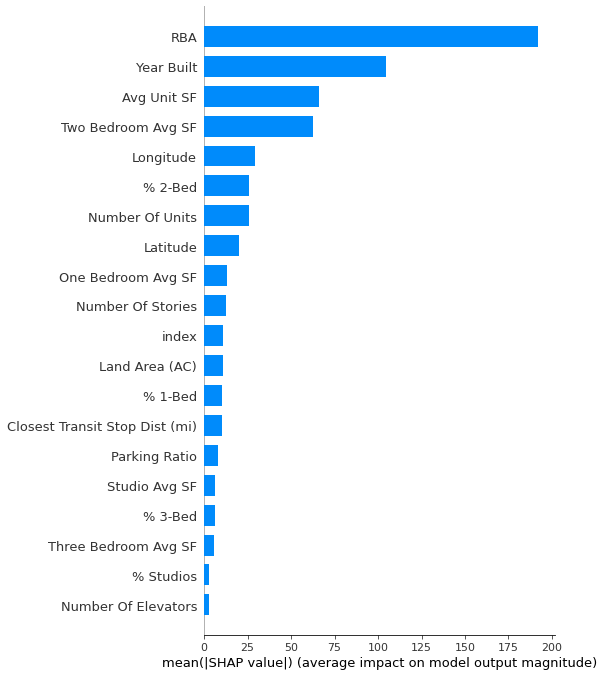

In [27]:
# Plot feature importance
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

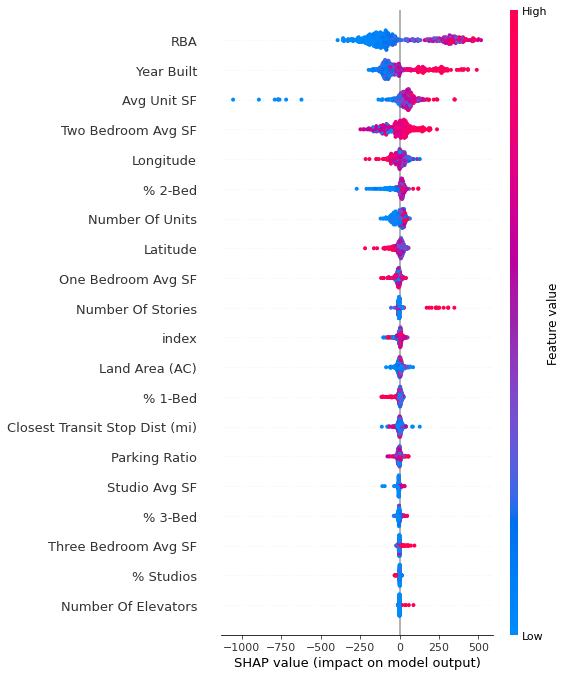

In [28]:
shap.summary_plot(shap_values, X_test)